In [1]:
import yaml
import sys
sys.path.append("../")
from plugins.interfaces.diagnostics import AWAFrameGrabberDiagnostic, ROI

# define screen and trim parameters
screen = "DYG5"
magnet_info = yaml.safe_load(open("awa_config/awa_drive_magnet_config.yml"))
screen_info = yaml.safe_load(open("awa_config/awa_drive_camera_config.yml"))[screen]

In [2]:
# create Xopt objects
from xopt import VOCS
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
            #"log10_total_intensity": ["GREATER_THAN", 5.55]
        }

vocs = VOCS(
    variables = {
        "AWA:Bira3Ctrl:Ch02":[-1.3,1.6], # SK3
        "AWA:Bira3Ctrl:Ch05":[-2.0,2.0], # DQ6
        "AWA:Drive:DS3:Ctrl": [130.0,250.0], # Matching solenoid
        "AWA:Drive:DS1:Ctrl": [450.0,550.0], # Bucking solenoid
    },
    constraints = IMAGE_CONSTRAINTS,
    observables = ["Sx_squared", "Sy_squared"],
)

In [3]:
vocs.variable_names

['AWA:Bira3Ctrl:Ch02',
 'AWA:Bira3Ctrl:Ch05',
 'AWA:Drive:DS1:Ctrl',
 'AWA:Drive:DS3:Ctrl']

In [4]:
screen_roi = ROI(
    xcenter=int(screen_info["center"][0]),
    ycenter=int(screen_info["center"][1]),
    xwidth=int(screen_info["radius"]*1.5),
    ywidth=int(screen_info["radius"]*1.5),
)

image_diagnostic = AWAFrameGrabberDiagnostic(
    roi=screen_roi, apply_bounding_box_constraint=True, visualize=False,
    save_image_location="../../awa_data/03_14_BAX/",
)

In [5]:
image_diagnostic

AWAFrameGrabberDiagnostic(screen_name='AWANIFrameGrabber', ip_address='N/A', alias=None, array_data_suffix='N/A', array_n_cols_suffix='N/A', array_n_rows_suffix='N/A', resolution_suffix=None, resolution=1.0, beam_shutter_pv=None, extra_pvs=[], background_file=None, save_image_location='../../awa_data/03_14_BAX/', roi=ROI(xcenter=293, ycenter=248, xwidth=310, ywidth=310), gain=1.0, min_log_intensity=4.0, bounding_box_half_width=3.0, wait_time=1.0, n_fitting_restarts=1, visualize=False, verbose=True, return_statistics=False, threshold=0.0, apply_bounding_box_constraint=True, target_charge=None, target_charge_pv=None, charge_atol=0.1, testing=False)

In [6]:
#image_diagnostic.measure_background()

In [7]:
#import matplotlib.pyplot as plt
#plt.imshow(image_diagnostic.background_image)

displaying image
fitting image
{'Cx': 197.04230093375955,
 'Cy': 165.33223755671025,
 'Sx': 10.020681616411109,
 'Sy': 33.07110935450475,
 'bb_penalty': -23.85402168633493,
 'log10_total_intensity': 6.816819554234701,
 'total_intensity': 6558727.0}


{'Cx': 197.04230093375955,
 'Cy': 165.33223755671025,
 'Sx': 10.020681616411109,
 'Sy': 33.07110935450475,
 'bb_penalty': -23.85402168633493,
 'total_intensity': 6558727.0,
 'log10_total_intensity': 6.816819554234701}

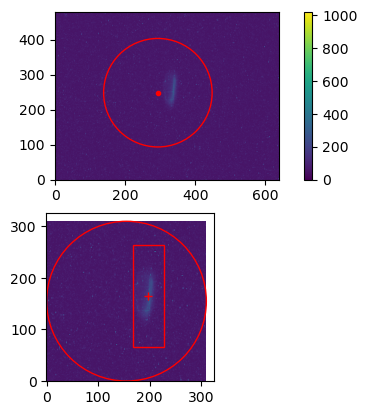

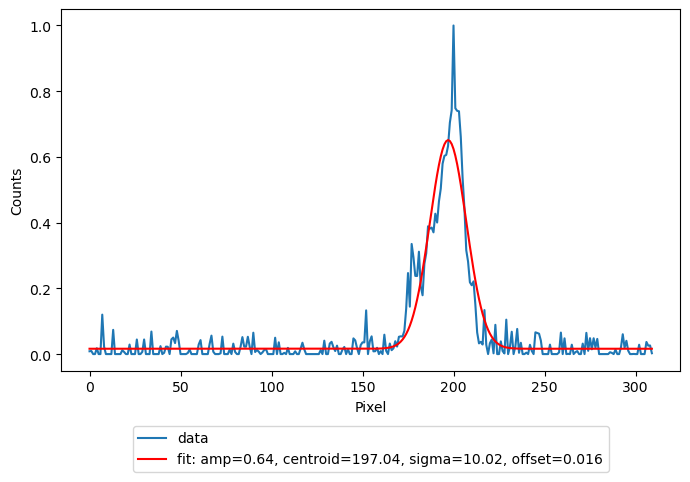

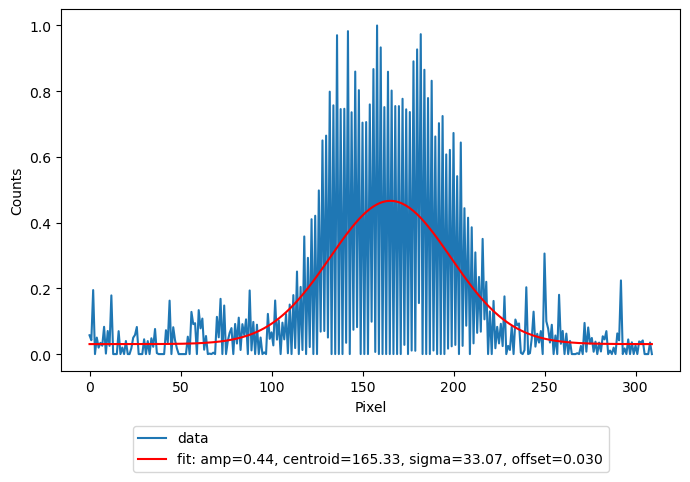

In [8]:
image_diagnostic.test_measurement()

In [9]:
import time
from xopt import Evaluator
from epics import caput

def evaluate(inputs: dict):
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(3.0)

    results = image_diagnostic.measure_beamsize(1, **inputs)
    results["Sx_m"] = results["Sx"] * 25 / screen_info["radius"]
    results["Sx_squared"] = results["Sx_m"]**2

    results["Sy_m"] = results["Sy"] * 25 / screen_info["radius"]
    results["Sy_squared"] = results["Sy_m"]**2
    
    # measure distance to image center
    print(results["Cx"], image_diagnostic.roi.xwidth/2)
    results["center_dist_x"] = results["Cx"] - image_diagnostic.roi.xwidth/2
    results["center_dist_y"] = results["Cy"] - image_diagnostic.roi.ywidth/2

    results["center_dist"] = (results["center_dist_x"]**2 + results["center_dist_y"]**2)**0.5
    results["time"] = time.time()
    
    return results

evaluator = Evaluator(function=evaluate)

In [10]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.super_low_noise import SuperLowNoiseModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.bayesian_exploration import BayesianExplorationGenerator
from xopt.numerical_optimizer import GridOptimizer
from copy import deepcopy
sys.path.append("../../emitopt/")
import torch
from emitopt.algorithms import ScipyMinimizeEmittanceXY

meas_dim = 1
tuning_dims = [0,2,3]
covar_module = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {'Sx_squared': scaled_covar_module, "Sy_squared": deepcopy(scaled_covar_module)}
# covar_module_dict = {}
model_constructor = SuperLowNoiseModelConstructor(
    covar_modules=covar_module_dict, use_low_noise_prior=True
)

generator = BayesianExplorationGenerator(
    vocs=vocs,
    gp_constructor=model_constructor, 
    numerical_optimizer=GridOptimizer(n_grid_points=10)
)



CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:52842, Ignored: 192.168.0.2:52842"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Mar 18 2024 16:48:08.956214015
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:52842, Ignored: awa3.hep.anl.gov:52842"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Mar 18 2024 16:48:08.957269869
..................................................................


In [11]:
from xopt import Xopt
X = Xopt(vocs=vocs, generator=generator, 
         evaluator=evaluator, strict=True,
         dump_file="grid_be_bax_skew_4.yml")

In [12]:
X


            Xopt
________________________________
Version: 2.2.1+8.g7a7eff90.dirty
Data size: 0
Config as YAML:
dump_file: grid_be_bax_skew_4.yml
evaluator:
  function: __main__.evaluate
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: bayesian_exploration
  numerical_optimizer:
    n_grid_points: 10
    name: grid
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints:
    bb_penalty:
    - LESS_THAN
    - 0.0
  objectives: {}
  observables:
  - Sx_

In [13]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd
import numpy as np
current_value = dict(zip(X.vocs.variable_names, caget_many(X.vocs.variable_names)))
print(current_value)


random_sample_region = get_local_region(current_value,X.vocs, fraction=0.1)
X.random_evaluate(10, custom_bounds=random_sample_region)

{'AWA:Bira3Ctrl:Ch02': -0.01111, 'AWA:Bira3Ctrl:Ch05': -1.555548, 'AWA:Drive:DS1:Ctrl': 483.3333435058594, 'AWA:Drive:DS3:Ctrl': 183.33334350585938}
fitting image
197.63617372772103 155.0
fitting image
194.20584976893124 155.0
fitting image
199.52267772140732 155.0
fitting image
195.89665155085353 155.0
fitting image
195.81952910434495 155.0
fitting image
nan 155.0
fitting image
194.5960725151143 155.0
fitting image
199.53046510508213 155.0
fitting image
192.74524170077498 155.0
fitting image
194.76197158884054 155.0


,AWA:Bira3Ctrl:Ch02,AWA:Bira3Ctrl:Ch05,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,...,Sx_m,Sx_squared,Sy_m,Sy_squared,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,0.108177,-1.910798,485.934396,187.619542,197.636174,168.041210,12.314326,38.586890,-3.597340,6508909.0,...,1.487541,2.212777,4.661203,21.726809,42.636174,13.041210,44.586057,1.710798e+09,4.266211,False
1,0.072742,-1.333972,473.459208,190.834049,194.205850,164.364477,6.788893,27.443140,-45.653500,6543462.0,...,0.820082,0.672534,3.315065,10.989654,39.205850,9.364477,40.308710,1.710798e+09,4.328433,False
2,-0.142966,-1.801448,487.324429,176.744083,199.522678,164.407507,10.794489,33.151320,-21.713190,6485851.0,...,1.303948,1.700280,4.004599,16.036812,44.522678,9.407507,45.505714,1.710799e+09,4.349398,False
3,0.162414,-1.719920,479.968978,191.577786,195.896652,170.233539,10.256039,37.101940,-9.576314,6537284.0,...,1.238905,1.534885,4.481824,20.086749,40.896652,15.233539,43.641687,1.710799e+09,4.315319,False
4,-0.129317,-1.694547,481.619894,191.082364,195.819529,168.598119,10.063205,32.691117,-22.664005,6504452.0,...,1.215611,1.477709,3.949007,15.594660,40.819529,13.598119,43.024909,1.710799e+09,4.397320,False
5,-0.117610,-1.931159,479.551915,176.246752,NaN,NaN,NaN,NaN,2.685711,6526652.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710799e+09,4.341039,False
6,-0.059146,-1.331097,487.274692,185.214091,194.596073,168.253776,7.083821,29.034462,-37.637388,6521847.0,...,0.855708,0.732237,3.507292,12.301101,39.596073,13.253776,41.755377,1.710799e+09,4.397145,False
7,0.059474,-1.566405,479.545218,174.035848,199.530465,160.660381,13.823534,40.331838,-1.905587,6612881.0,...,1.669849,2.788397,4.871988,23.736268,44.530465,5.660381,44.888776,1.710799e+09,4.398862,False
8,-0.280570,-1.726629,482.312436,195.105246,192.745242,175.686677,9.574340,32.437201,-19.568750,6460796.0,...,1.156557,1.337624,3.918335,15.353350,37.745242,20.686677,43.042327,1.710799e+09,4.428765,False
9,0.204588,-1.549813,492.112693,185.425926,194.761972,165.314880,7.775564,35.621754,-21.915947,6529577.0,...,0.939269,0.882227,4.303021,18.515993,39.761972,10.314880,41.078110,1.710799e+09,4.394893,False


In [14]:
for i in range(40):
    X.step()

fitting image
191.413245739634 155.0
fitting image
184.017487983941 155.0
fitting image
196.50770468789202 155.0
fitting image
190.75767483149383 155.0
fitting image
195.23491247247173 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


fitting image
nan 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


fitting image
nan 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


fitting image
183.04940851666902 155.0
fitting image
181.68268009021725 155.0
fitting image
194.97425936903852 155.0
fitting image
193.06625003160912 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


fitting image
192.58365806552925 155.0
fitting image
189.74021077535576 155.0
fitting image
186.13600969208832 155.0
fitting image
192.26647501330524 155.0
fitting image
194.39894565872828 155.0
fitting image
185.20272460875364 155.0
fitting image
189.75601489379355 155.0
fitting image
192.96989792402923 155.0
fitting image
197.3235200556996 155.0
fitting image
182.90624151819742 155.0
fitting image
nan 155.0
fitting image
nan 155.0
fitting image
193.56905180165276 155.0
fitting image
191.5692379260582 155.0
fitting image
181.29880941511956 155.0
fitting image
188.38532128986213 155.0
fitting image
183.03396859322794 155.0
fitting image
159.96423263989894 155.0
fitting image
nan 155.0
fitting image
172.3127433728485 155.0
fitting image
nan 155.0
fitting image
167.1970207300046 155.0
fitting image
154.22803188035735 155.0
fitting image
177.26321071970327 155.0
fitting image
nan 155.0
fitting image
186.09618291093292 155.0
fitting image
188.7086136980738 155.0
fitting image
182.861215736

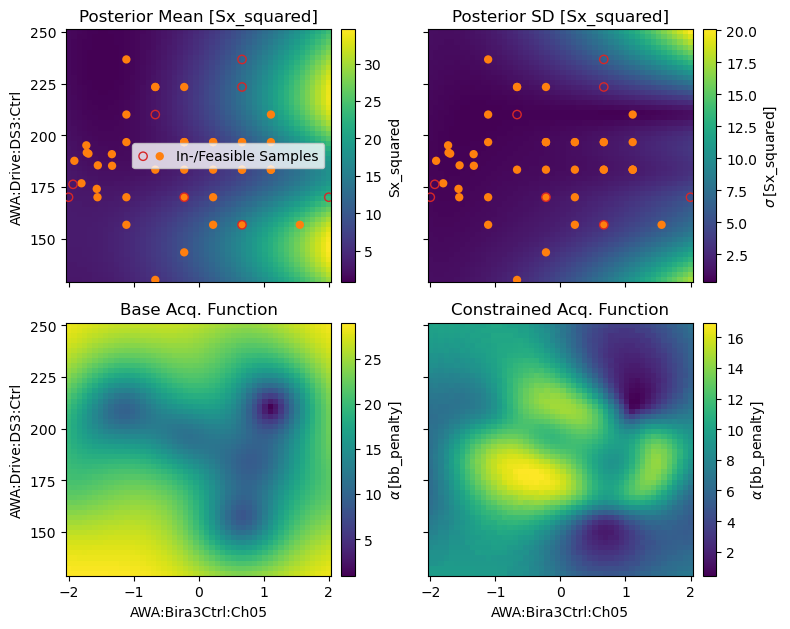

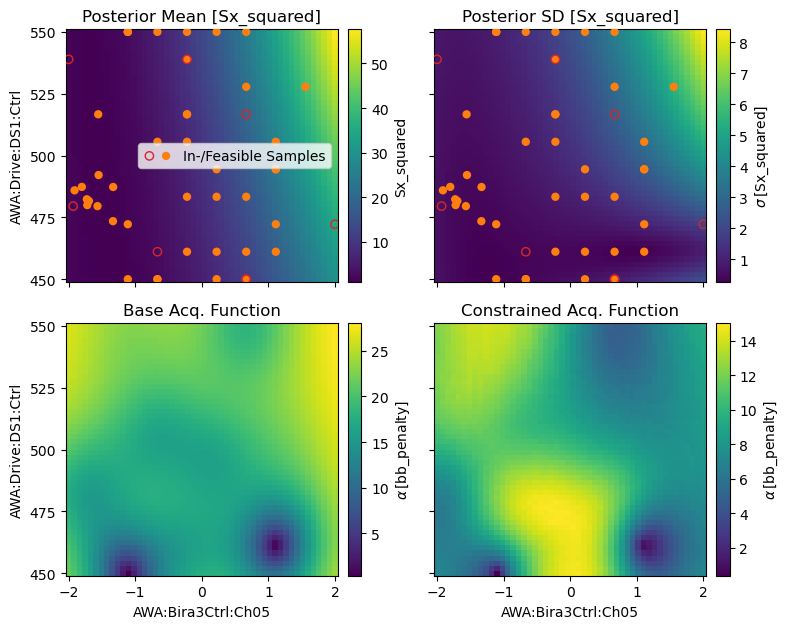

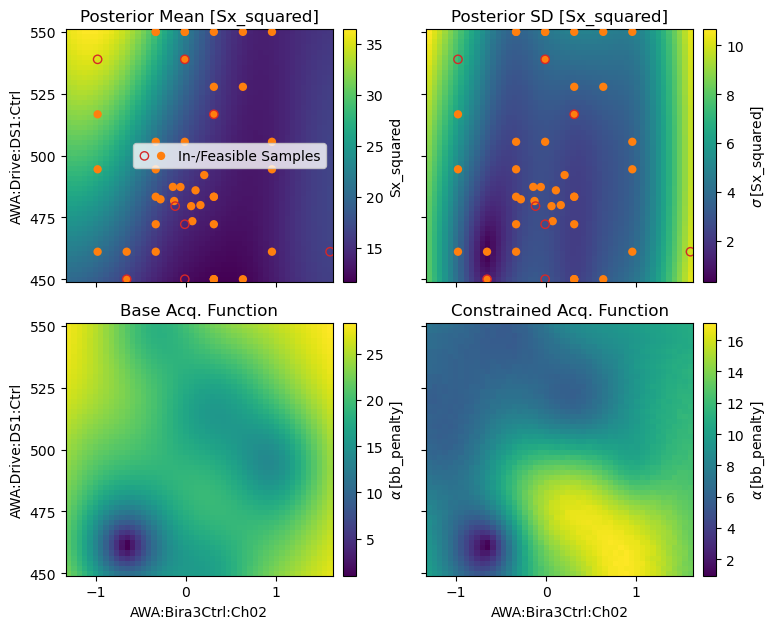

In [15]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch05","AWA:Drive:DS3:Ctrl"],
    output_names=["Sx_squared"],
)

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch05","AWA:Drive:DS1:Ctrl"],
    output_names=["Sx_squared"],
)
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch02","AWA:Drive:DS1:Ctrl"],
    output_names=["Sx_squared"],
)

#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)


In [36]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.super_low_noise import SuperLowNoiseModelConstructor
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.bayesian_exploration import BayesianExplorationGenerator
from xopt.numerical_optimizer import GridOptimizer
from copy import deepcopy
sys.path.append("../../emitopt/")
import torch
from emitopt.algorithms import ScipyMinimizeEmittanceXY

meas_dim = 1
tuning_dims = [0,2,3]
covar_module = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {'Sx_squared': scaled_covar_module, "Sy_squared": deepcopy(scaled_covar_module)}
# covar_module_dict = {}
model_constructor = StandardModelConstructor(
    covar_modules=covar_module_dict, use_low_noise_prior=True
)

from emitopt.utils import get_quad_scale_factor
q_len=0.1

pv_scale = (q_len*10 / 0.893) # [kG] / [A] for AWA Blue quads
geo_scale_factor = get_quad_scale_factor(E=0.060, q_len=q_len) # [m^-2] / [kG] 


scale_factor = pv_scale * geo_scale_factor
rmat_x = torch.tensor(((1.0,2.375),(0.0,1.0)))
rmat_y = torch.tensor(((1.0,2.375),(0.0,1.0)))
n_samples=10

algo_kwargs = {
        'x_key': 'Sx_squared',
        'y_key': 'Sy_squared',
        'scale_factor': scale_factor,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 11,
#         'scipy_options': None,
        'thick_quad': False,
}
algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

generator = BaxGenerator(
    vocs=vocs, 
    gp_constructor=model_constructor, 
    algorithm=algo,
    numerical_optimizer=GridOptimizer(n_grid_points=10)
    #n_interpolate_points=5,
)


from xopt import Xopt
X_bax = Xopt(vocs=vocs, generator=generator, 
         evaluator=evaluator, strict=True,
            dump_file="grid_be_bax_skew_4.yml"
)#,dump_file="bax_emittance_3d_x_y_2.yml")
X_bax.add_data(X.data)


In [37]:
for i in range(10):
    X_bax.step()

/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


fitting image
181.62154260214194 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


fitting image
190.57609223444715 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


fitting image
190.16294135999297 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


fitting image
190.16397886877542 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


fitting image
168.32078926403375 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


fitting image
190.0966104036813 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


fitting image
185.22435963808172 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


fitting image
162.22379658902278 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


fitting image
191.10723731853525 155.0


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


fitting image
190.12109517538164 155.0


<Axes: >

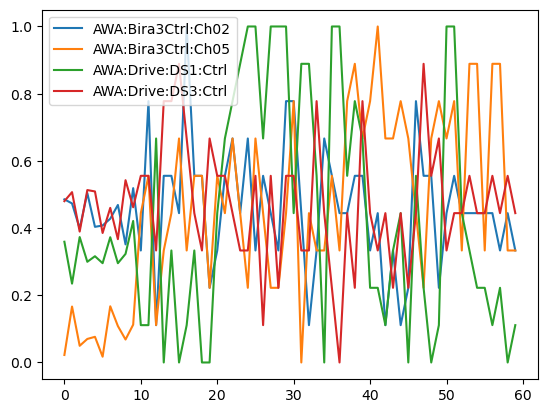

In [38]:
X_bax.vocs.normalize_inputs(X_bax.data).plot(y=X_bax.vocs.variable_names)

<Axes: >

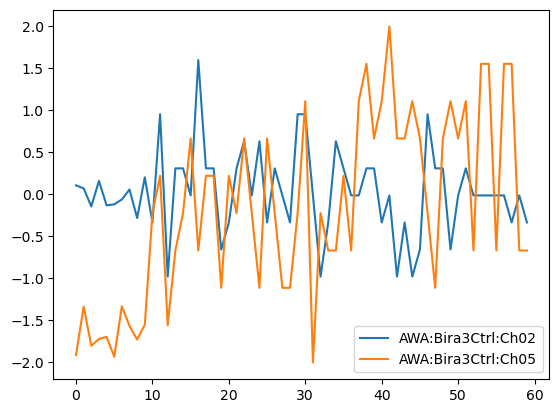

In [39]:
X_bax.data.plot(y=X_bax.vocs.variable_names[:2])

/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


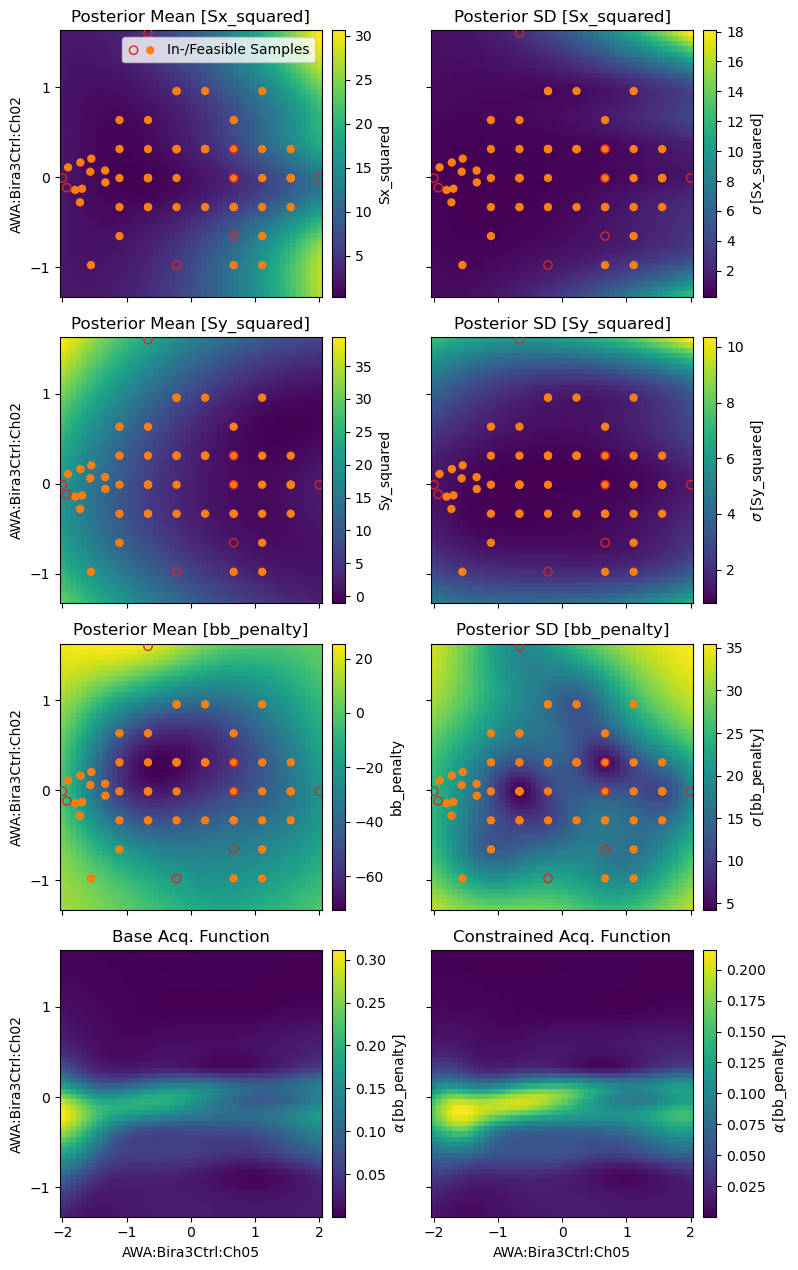

In [40]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X_bax.generator.train_model()
fig,ax = visualize_generator_model(
    X_bax.generator, 
    reference_point={"AWA:Drive:DS1:Ctrl":450.0,"AWA:Drive:DS3:Ctrl":200.0},
    variable_names=["AWA:Bira3Ctrl:Ch05","AWA:Bira3Ctrl:Ch02"],
    output_names=["Sx_squared","Sy_squared","bb_penalty"],
)

/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


(<Figure size 900x600 with 6 Axes>,
 array([[<Axes: xlabel='AWA:Bira3Ctrl:Ch02', ylabel='Emittance'>,
         <Axes: xlabel='AWA:Drive:DS1:Ctrl'>,
         <Axes: xlabel='AWA:Drive:DS3:Ctrl'>],
        [<Axes: xlabel='AWA:Bira3Ctrl:Ch02', ylabel='Sample Validity Rate'>,
         <Axes: xlabel='AWA:Drive:DS1:Ctrl'>,
         <Axes: xlabel='AWA:Drive:DS3:Ctrl'>]], dtype=object))

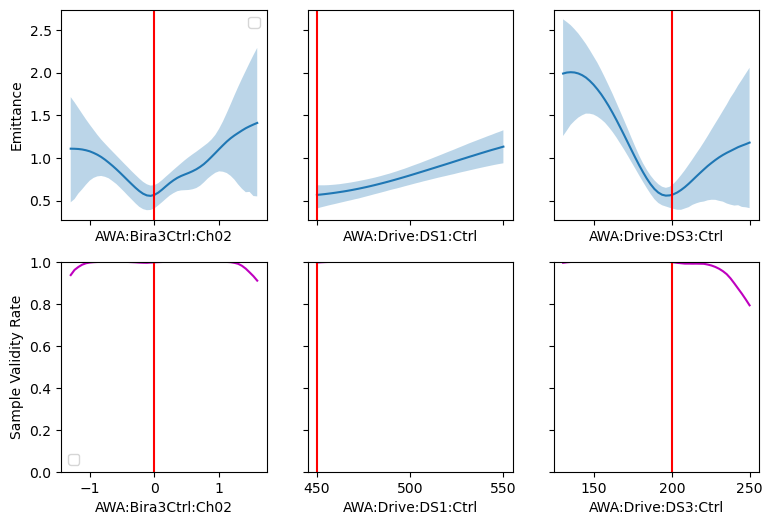

In [41]:
from emitopt.plot_utils import plot_virtual_emittance_vs_tuning, plot_pathwise_emittance_vs_tuning
plot_virtual_emittance_vs_tuning(X_bax, torch.tensor([[0.0,450.,200]]),n_points=50)

In [47]:
X_bax.generator.algorithm_results["x_tuning_best"].mean(dim=0)

tensor([[-1.5754e-01,  4.7180e+02,  1.9079e+02]], dtype=torch.float64)

In [48]:
quad_scan = {
    "AWA:Drive:DS1:Ctrl":4.7180e+02,
    "AWA:Drive:DS3:Ctrl":1.9079e+02,
    "AWA:Bira3Ctrl:Ch02": -1.5754e-01,
    "AWA:Bira3Ctrl:Ch05": np.linspace(-2.0,2.0,30)
}
X_bax.evaluate_data(quad_scan)

fitting image
196.4736671599745 155.0
fitting image
197.2592729536246 155.0
fitting image
196.23952760925016 155.0
fitting image
195.21986938956914 155.0
fitting image
193.59894927203115 155.0
fitting image
193.85071068389436 155.0
fitting image
192.90440815994134 155.0
fitting image
192.2712236760777 155.0
fitting image
191.74893096064216 155.0
fitting image
191.46197909521948 155.0
fitting image
190.3450512388776 155.0
fitting image
189.611595852416 155.0
fitting image
189.91695699418193 155.0
fitting image
189.48072636918118 155.0
fitting image
188.9753466949599 155.0
fitting image
187.696630664027 155.0
fitting image
186.20623624390322 155.0
fitting image
186.90781826504244 155.0
fitting image
183.78316090208344 155.0
fitting image
183.99548185812532 155.0
fitting image
185.24937336770637 155.0
fitting image
182.55893654206028 155.0
fitting image
186.64786933695726 155.0
fitting image
185.34521166210294 155.0
fitting image
180.1617815483472 155.0
fitting image
182.09955297441508 15

,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWA:Bira3Ctrl:Ch02,AWA:Bira3Ctrl:Ch05,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,...,Sx_m,Sx_squared,Sy_m,Sy_squared,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,471.8,190.79,-0.15754,-2.000000,196.473667,172.239417,11.325982,34.843555,-11.748827,6398868.0,...,1.368151,1.871837,4.209017,17.715822,41.473667,17.239417,44.913946,1.710800e+09,4.301916,False
1,471.8,190.79,-0.15754,-1.862069,197.259273,166.592862,11.296228,34.022351,-18.189591,6433124.0,...,1.364557,1.862016,4.109817,16.890599,42.259273,11.592862,43.820550,1.710800e+09,4.273662,False
2,471.8,190.79,-0.15754,-1.724138,196.239528,172.323106,9.674967,30.889936,-24.479767,6444969.0,...,1.168713,1.365889,3.731429,13.923564,41.239528,17.323106,44.730176,1.710800e+09,4.307694,False
3,471.8,190.79,-0.15754,-1.586207,195.219869,169.899601,8.267430,27.904193,-36.880384,6431299.0,...,0.998686,0.997373,3.370759,11.362015,40.219869,14.899601,42.890978,1.710800e+09,4.291929,False
4,471.8,190.79,-0.15754,-1.448276,193.598949,166.036152,7.265996,27.142218,-44.559245,6427108.0,...,0.877715,0.770383,3.278714,10.749966,38.598949,11.036152,40.145679,1.710800e+09,4.328452,False
5,471.8,190.79,-0.15754,-1.310345,193.850711,167.660571,7.069412,27.417721,-42.680393,6458229.0,...,0.853968,0.729261,3.311994,10.969305,38.850711,12.660571,40.861568,1.710800e+09,4.292333,False
6,471.8,190.79,-0.15754,-1.172414,192.904408,165.581987,6.570366,25.394212,-50.847965,6466945.0,...,0.793684,0.629935,3.067559,9.409919,37.904408,10.581987,39.353813,1.710800e+09,4.324249,False
7,471.8,190.79,-0.15754,-1.034483,192.271224,168.679822,6.037824,25.000872,-50.443606,6460969.0,...,0.729355,0.531958,3.020045,9.120669,37.271224,13.679822,39.702414,1.710800e+09,4.306872,False
8,471.8,190.79,-0.15754,-0.896552,191.748931,168.835168,6.150840,24.611214,-51.399707,6474704.0,...,0.743007,0.552059,2.972975,8.838580,36.748931,13.835168,39.266981,1.710800e+09,4.335153,False
9,471.8,190.79,-0.15754,-0.758621,191.461979,168.053570,6.731771,23.884957,-53.090390,6531875.0,...,0.813182,0.661264,2.885245,8.324638,36.461979,13.053570,38.728176,1.710800e+09,4.389068,False


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


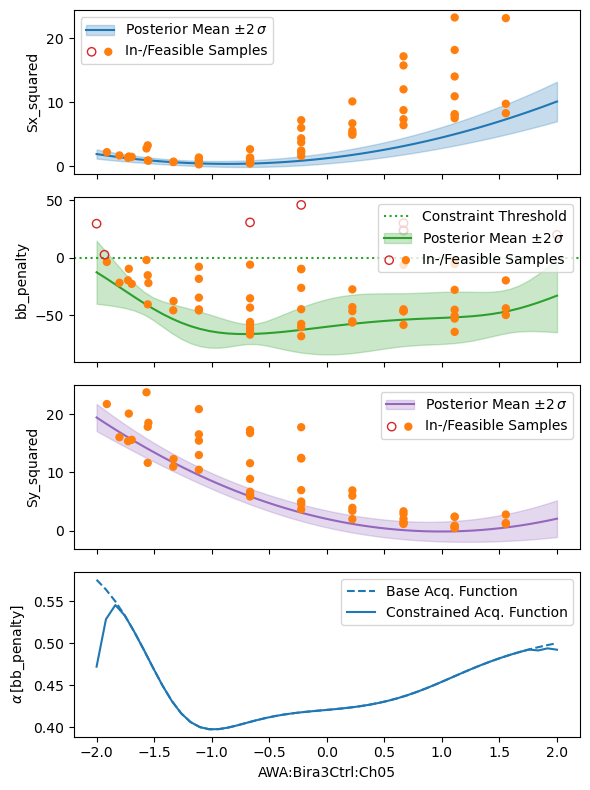

In [23]:
fig,ax = visualize_generator_model(
    X_bax.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch05"],
    output_names=["Sx_squared","bb_penalty","Sy_squared"],
    reference_point={
        "AWA:Drive:DS1:Ctrl":450.0,
        "AWA:Drive:DS3:Ctrl":200,
        "AWA:Bira3Ctrl:Ch02": 0.0,
    },
)

/tmp/ipykernel_1397456/971761469.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_bax.data[X_bax.data["AWA:Drive:DS1:Ctrl"]==550.0][X_bax.data["AWA:Drive:DS3:Ctrl"]==210.0].plot(


<Axes: xlabel='AWA:Bira3Ctrl:Ch05'>

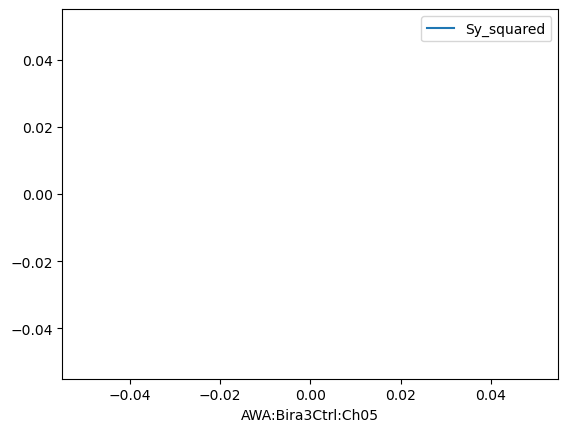

In [24]:
X_bax.data[X_bax.data["AWA:Drive:DS1:Ctrl"]==550.0][X_bax.data["AWA:Drive:DS3:Ctrl"]==210.0].plot(
    x="AWA:Bira3Ctrl:Ch05",y="Sy_squared"
)

In [25]:
X_bax.data["AWA:Drive:DS3:Ctrl"].unique()

array([187.61954185, 190.8340493 , 176.7440829 , 191.57778552,
       191.08236402, 176.24675178, 185.21409051, 174.03584766,
       195.105246  , 185.42592574, 196.66665649, 170.        ,
       223.33332825, 236.66665649, 210.        , 183.33334351,
       143.33334351, 156.66667175, 130.00001526])

In [26]:
X_bax.dump_file = "grid_be_bax_skew_2.yml"
X_bax.dump()

array([[<Axes: title={'center': 'AWA:Drive:DS3:Ctrl'}>]], dtype=object)

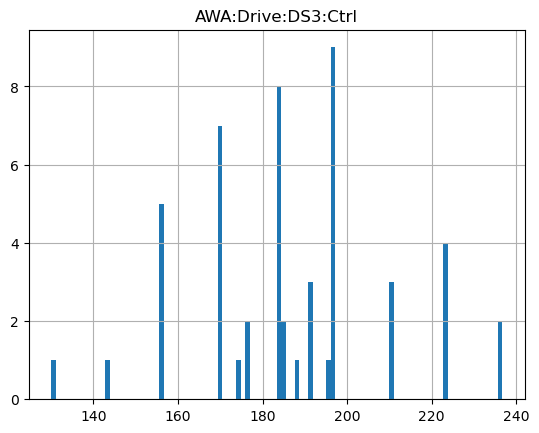

In [27]:
X.data.hist("AWA:Drive:DS3:Ctrl",bins=100)

In [28]:
X.data.tail(20)

,AWA:Bira3Ctrl:Ch02,AWA:Bira3Ctrl:Ch05,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,...,Sx_m,Sx_squared,Sy_m,Sy_squared,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
30,0.95555,1.111106,494.444458,196.666656,182.906242,153.747927,30.982772,12.725558,-27.876242,6487258.0,...,3.742644,14.007381,1.537216,2.363034,27.906242,-1.252073,27.934316,1.710799e+09,4.218668,False
31,-0.01111,-1.999990,538.888916,170.000000,NaN,NaN,NaN,NaN,29.699251,6563739.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710799e+09,4.247808,False
32,-0.97777,-0.222221,538.888916,170.000000,NaN,NaN,NaN,NaN,46.041818,6632194.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710799e+09,4.340124,False
33,-0.33333,-0.666663,505.555542,223.333328,193.569052,178.097432,13.519371,34.401640,-5.958419,6534779.0,...,1.633107,2.667039,4.155635,17.269299,38.569052,23.097432,44.956236,1.710799e+09,4.285743,False
34,0.63333,-0.666663,450.000000,183.333344,191.569238,160.725751,9.738448,28.170244,-43.329798,6584080.0,...,1.176381,1.383872,3.402897,11.579708,36.569238,5.725751,37.014773,1.710799e+09,4.309499,False
35,0.31111,0.222221,550.000000,156.666672,181.298809,161.287657,18.844806,16.424256,-55.258814,6696937.0,...,2.276407,5.182028,1.984010,3.936296,26.298809,6.287657,27.040008,1.710799e+09,4.255976,False
36,-0.01111,-0.666663,550.000000,130.000015,188.385321,148.343513,5.916182,33.888118,-35.216541,6853560.0,...,0.714660,0.510740,4.093602,16.757580,33.385321,-6.656487,34.042451,1.710799e+09,4.359182,False
37,-0.01111,1.111106,505.555542,183.333344,183.033969,162.119811,23.631222,6.032901,-52.908618,6575642.0,...,2.854594,8.148708,0.728760,0.531091,28.033969,7.119811,28.923954,1.710799e+09,4.315537,False
38,0.31111,1.555548,527.777771,156.666672,159.964233,166.995770,39.790454,13.810969,-19.670907,6572568.0,...,4.806590,23.103309,1.668332,2.783330,4.964233,11.995770,12.982377,1.710799e+09,4.291080,False
39,0.31111,0.666663,516.666687,223.333328,NaN,NaN,NaN,NaN,30.184968,6528823.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710799e+09,4.301320,False


In [29]:
from emitopt.plot_utils import plot_virtual_measurement_scan
plot_virtual_measurement_scan(X, torch.tensor([[220.]]))

AttributeError: 'BayesianExplorationGenerator' object has no attribute 'algorithm'

In [ ]:
from xopt.generators.bayesian.visualize import visualize_generator_model

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.25},
    output_names=["Cx"]
)

fig2,ax2 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.0},
    output_names=["Cx"]
)

fig3,ax3 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cx"]
)

In [ ]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)
#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)


In [ ]:
import yaml
with open("bax_scan_1.yml") as stream:
    d =yaml.safe_load(stream)
import pandas as pd
import torch
df =pd.DataFrame(d['data'])
df

df2 =df[df['AWA:Drive:DS3:Ctrl'] == 230.]
df2
df3 =df2.dropna()
df3

x = torch.tensor(df3['AWA:Bira3Ctrl:Ch03'])
y = torch.tensor(df3['Sx_squared'])

from emitopt.utils import get_quad_scale_factor
q_len = 0.1
pv_scale = (q_len*10 / 0.893) # [kG] / [A] for AWA Blue quads
geo_scale_factor = get_quad_scale_factor(E=0.060, q_len=q_len) # [m^-=2] / [kG]

scale_factor =pv_scale * geo_scale_factor
k =scale_factor * x
k

import matplotlib.pyplot as plt
plt.scatter(k, y)
plt.figure()

from emitopt.analysis import compute_emit_bmag, compute_emit_bayesian
rmat_x =torch.tensor(((1.0,2.375),(0.0,1.0)))
#emit = compute_emit_bmag(k, y, q_len, rmat_x)[0]
emit =compute_emit_bayesian(
    k, y.sqrt(), q_len, 
    rmat_x,visualize=True,noise_prior=GammaPrior(1.0, 10.0))[0]
plt.hist(emit)


In [ ]:
x_tuning =  torch.tensor([[220.]])
n_samples = 100

bax_model_ids = [
    X.generator.vocs.output_names.index(name)
    for name in X.generator.algorithm.observable_names_ordered
]
bax_model = X.generator.model.subset_output(bax_model_ids)

x = X.generator.algorithm.get_meas_scan_inputs(x_tuning, X.generator.vocs.bounds) # result shape n_tuning_configs*n_steps x ndim

p = bax_model.posterior(x)
bss = p.sample(torch.Size([n_samples])) # result shape n_samples x n_tuning_configs*n_steps x num_outputs (1 or 2)

x = x.reshape(x_tuning.shape[0], X.generator.algorithm.n_steps_measurement_param, -1) # result n_tuning_configs x n_steps x ndim
x = x.repeat(n_samples,1,1,1)
# result shape n_samples x n_tuning_configs x n_steps x ndim
bss = bss.reshape(n_samples, x_tuning.shape[0], X.generator.algorithm.n_steps_measurement_param, -1)
# result shape n_samples x n_tuning_configs x n_steps x num_outputs (1 or 2)

In [ ]:
import matplotlib.pyplot as plt
from emitopt.analysis import compute_emit_bmag, compute_emit_bayesian

for i in range(40):
    plt.plot(x[i,0,:,0],bss[i,0,:,0],'C0')
    emit = compute_emit_bmag(
        scale_factor *x[i,0,:,0],bss[i,0,:,0], q_len, rmat_x,thick=False
    )[0]
    print(emit)

plt.ylim(-0.75,14)
plt.xlim(-0.8,0.6)